<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_inception_v3_BalanceoSklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3 con Balanceo Sklearn

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 7.2 MB/s 
     |████████████████████████████████| 60 kB 8.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.8 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
from fastai.vision.all import *

In [ ]:
!pip install wwf
# !pip install nbdev

In [3]:
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-17 07:28:58 URL:https://uc817725eeabccd07ced3bf8c72b.dl.dropboxusercontent.com/cd/0/inline2/BnUTVdBEWFDu-R6aLK0onWGeqlW3QevExcSMP-zjuxwSu7BnsE1wDtcGITddaavzXFbPTTuuSZJIcVQAUWkNqNs7WGfxPnbTc7Tw1HXd4AKE8NHG8l6Nb9oUhUHB-Js8mk7uLnWRlampFbn2X8UJ97vtlEwfbFQNetveHz65HuUSqo0nOyqchju0eXjxyvo0OL8TbUOQ27lQLydW1CogX9b80dQSWKvh9lGWO2NEcYtp7PRXnP3PJyvu1UcOW0QQ4DtRJIx2bZJBHnQ5yZS6ZzQiIgXC38KEqW-J-GYrz09MeklzFIURgGKlhLjY2oXv_Anpyv0DZY-beZ_5nGM6iFX2bjmQyw5Eu45BAAZq-d-FOWX89IXC6IvPx8AHdujuDZdrFkgyS5Z2rw0B1igTHkogqMvJcRaOyC85u_tuS6amAA/file [138777773/138777773] -> "train.zip" [1]
2022-06-17 07:29:00 URL:https://uc8442aefb08846e6f7020c563af.dl.dropboxusercontent.com/cd/0/inline2/BnUB7QnkGB68zWfTVeSPmPemYDwoExCkZy-HTd5UB-PUkY_ubq_12yTLlZbYnVf6HxXdQqcQaFwjPaoD49t0SR7A_aI3kn2bR_Us9t17ilRfQILRUFdjqop9ANuc3WSmQOpVMBlrImbnrESRomNa84SG4XRMB6MsurZZRJpv4k_PoUIb6GrNfv9qz2y5w4E_S2mtmW2A4DPuEnDfiOZF5UMVw2XzXO7KMIHZmncVx74zKX8ijmTZjqDQUDTgUCF49z7l7NulQhcloIzej0Y2z_3_kZiwlxD_r76S2cPTQ1LPZc3HukPCkL-2tkmRtgyDOvU

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [7]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [10]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [11]:
path = Path('dataset')

## Balanceo

In [12]:
from sklearn.utils import resample

In [13]:
df_majority = df_train[df_train.Disease_Risk==1] #mayoria de instacias con enfermedad respecto a sin ella.
df_minority = df_train[df_train.Disease_Risk==0]

In [14]:
# Aumentar la muestra de la clase minoritaria
# Aumentar la muestra de la clase minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # muestra con remplazamiento
                                 n_samples=960,    # número de muestras de la clase mayoritaria
                                 random_state=42) # semilla para que los resultados sean reproducibles

# Disminuir la clase mayoritaria
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # muestra sin remplazamiento
                                 n_samples=960,     # número de muestras de la clase minoritaria
                                 random_state=42) # semilla para que los datos sean reproducibles
                               
# Combinar el nuevo grupo con el grupo original mayoritario
df_train = pd.concat([df_majority_downsampled, df_minority_upsampled])
df_train = df_train.reset_index(drop=True)

# Mostrar el número de instancias en cada clase
df_train.Disease_Risk.value_counts()

1    960
0    960
Name: Disease_Risk, dtype: int64

In [16]:
len(df_minority_upsampled.ID.unique())

359

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [17]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [18]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [19]:
dls = db.dataloaders(path,bs=128)

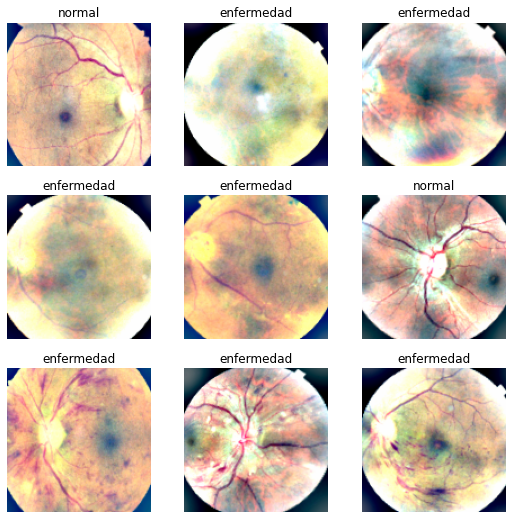

In [20]:
dls.show_batch()

In [21]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [32]:
learn = timm_learner(dls, 'inception_v3', metrics=[error_rate, accuracy], cbs=callbacks)

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.021516,1.124475,0.354688,0.645312,00:10


Better model found at epoch 0 with valid_loss value: 1.1244747638702393.


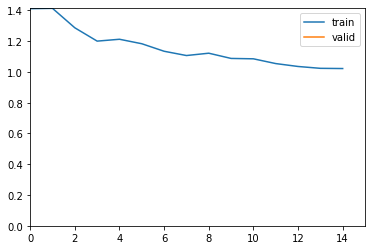

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.848212,0.671235,0.251563,0.748438,00:13
1,0.838413,0.744811,0.279687,0.720312,00:12
2,0.793253,0.673532,0.262500,0.737500,00:12
3,0.735877,0.607856,0.239063,0.760938,00:13
4,0.697954,0.606495,0.240625,0.759375,00:12
5,0.665774,0.690045,0.259375,0.740625,00:12
6,0.638836,0.656028,0.262500,0.737500,00:13
7,0.613178,0.689271,0.278125,0.721875,00:14
8,0.588908,0.630564,0.267188,0.732813,00:12
9,0.569509,0.577113,0.239063,0.760938,00:12


Better model found at epoch 0 with valid_loss value: 0.6712345480918884.


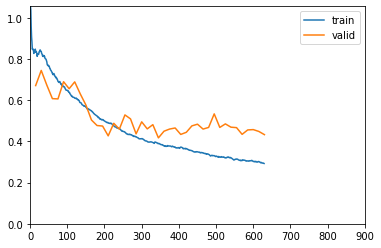

Better model found at epoch 3 with valid_loss value: 0.607856273651123.
Better model found at epoch 4 with valid_loss value: 0.6064947843551636.
Better model found at epoch 9 with valid_loss value: 0.5771132707595825.
Better model found at epoch 10 with valid_loss value: 0.5040947198867798.
Better model found at epoch 11 with valid_loss value: 0.47728976607322693.
Better model found at epoch 12 with valid_loss value: 0.4746948182582855.
Better model found at epoch 13 with valid_loss value: 0.42710772156715393.
Better model found at epoch 22 with valid_loss value: 0.4173475205898285.
No improvement since epoch 22: early stopping


In [24]:
learn.fine_tune(60,base_lr=3e-3)

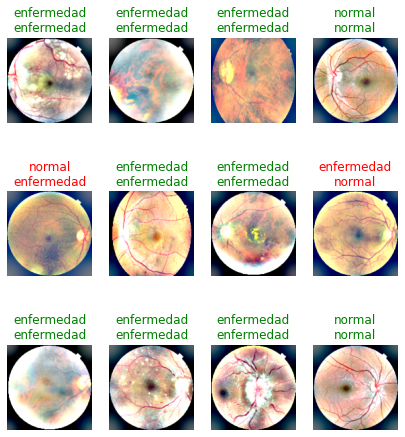

In [25]:
learn.show_results(max_n=12, figsize=(7,8))

## Evaluando el Modelo

In [26]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [27]:
learn.dls = dlsTest

Obtenemos una accuracy de 0.78.

In [28]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.2109375.


(#3) [0.4414190649986267,0.2109375,0.7890625]

Exportamos el modelo:

In [29]:
learn.to_fp32()
learn.export('modeloBinario_efficientnet_b3_BalanceoSklean.pkl')